In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

In [ ]:
import matplotlib.pyplot as plt
from keras import layers
import keras

In [1]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import util

In [2]:
model_s = SentenceTransformer('all-mpnet-base-v2')

In [5]:
emb1 = model_s.encode("Jo Malone London™ Dark Amber & Ginger Lily Scented Home Candle NO COLOR  7 oz—")
emb2 = model_s.encode("Jo Malone London Dark Amber & Ginger Lily Home Candle")

In [6]:
cos_sim = util.cos_sim(emb1, emb2)
print("Cos similarity: ", cos_sim)

Cos similarity:  tensor([[0.9259]])


In [7]:
import json

data = []
for line in open('data/33318.json', 'r'):
    data.append(json.loads(line))
    
df = pd.io.json.json_normalize(data)

C:\Users\Akshay\.conda\envs\pytorchenv\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  import sys


In [8]:
docs = {}

for i in range(len(df)):
    dp = {}
    #dp['index'] = i
    dp['seed'] = df['seed_name'][i]  ## query product title
    
    del_titles = []
    active_titles = []
    
    s = len(df['detailed'][i])
    for l in range(s):
        if df['detailed'][i][l]['status'] == 'deleted':
            del_titles.append(df['detailed'][i][l]['title'])   ## title of deleted prod
            
        if df['detailed'][i][l]['status'] == 'active':
            active_titles.append(df['detailed'][i][l]['title'])  ## title of accepted prod
    
    dp['active_titles'] = active_titles
    dp['deleted_titles'] = del_titles
    
    docs[i] = dp

In [9]:
df_processed = pd.DataFrame(docs.values())
df_processed.head()

,seed,active_titles,deleted_titles
0,Clarks Desert Trek Black Suede 1,[Clarks Desert Trek Black Suede 1],"[, 883956040685, (DARK WOOD/DARK JAVA) [8.5]---]"
1,Haflinger GZ Classic Grizzly Bordo,"[Haflinger GZ Classic Grizzly Bordo, Haflinger...",[Mens Birkenstock Zermatt Clog - Mocha Mocha |...
2,Nike Air Zoom Terra Kiger 7 Limelight/Off-Noir...,[Nike Air Zoom Terra Kiger 7 Limelight/Off-Noi...,[Nike Air Monarch IV Training Shoe - Men's Whi...
3,adidas Originals Trefoil Tee White/Hazy Rose,[adidas Originals Trefoil Tee White/Hazy Rose],"[Men's adidas Orlando City Away Soccer Jersey""..."
4,Save the Duck Kids Flee (Little Kids/Big Kids)...,[Save the Duck Kids Flee (Little Kids/Big Kids...,[Save The Duck Randolph Bomber Jacket NAVY BLU...


In [10]:
df_processed['seed'] = [ '' if x is np.NaN else x for x in df_processed['seed'] ]
df_processed['active_titles'] = [ '' if x is np.NaN else x for x in df_processed['active_titles'] ]
df_processed['deleted_titles'] = [ '' if x is np.NaN else x for x in df_processed['deleted_titles'] ]

In [185]:
seeds = []
for row in df_processed['seed']:
    if len(row) != 0:
        seeds.append(row)
    
len(seeds)

17000

In [186]:
active_titles = []
for row in df_processed['active_titles']:
    if len(row) != 0:
        active_titles.append(row[0])
    
len(active_titles)

17000

In [187]:
deleted_titles = []
for row in df_processed['deleted_titles']:
    if len(row) != 0: 
        deleted_titles.append(row[0])
    
len(deleted_titles)

15888

In [203]:
docs_all = []
for i in range(len(seeds)):
    docs_all.append(seeds[i])
    
for i in range(len(active_titles)):
    docs_all.append(active_titles[i])
    
for i in range(len(deleted_titles)):
    docs_all.append(deleted_titles[i])
    
print(len(docs_all))

49888


In [204]:
vectors = []
for i in range(len(docs_all)):
    vectors.append(model_s.encode(docs_all[i]))

vectors = np.array(vectors)
vectors.shape

(49888, 768)

In [205]:
np.save('33318_seed_active_del_titles_vectors', vectors)

In [15]:
vectors = np.load('33318_seed_active_del_titles_vectors.npy')

In [172]:
df_processed['seed'].iloc[4558]

'NIC+ZOE Four-Way Cardigan Blue Haze'

In [173]:
df_processed['active_titles'].iloc[4558]

['NIC+ZOE NIC+ZOE Four-Way Cardigan Blue Haze',
 'NIC+ZOE Calm Waters Open Cardigan BLUE HAZE LARGE']

In [17]:
X = vectors

In [18]:
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [19]:
print(X_train.shape)
print(X_test.shape)

(44899, 768)
(4989, 768)


In [259]:
emb_dim = 768
hidden_layer_1_size = 600
hidden_layer_2_size = 500

In [316]:
encoder = Sequential()
encoder.add(InputLayer((768,)))
encoder.add(InputLayer((emb_dim, ) ))
encoder.add(Dense(hidden_layer_1_size, activation='relu'))
encoder.add(Dense(hidden_layer_2_size, activation='relu'))

decoder = Sequential()
decoder.add(InputLayer((hidden_layer_2_size, )))
decoder.add(Dense(emb_dim, activation='sigmoid'))

In [317]:
encoder.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 600)               461400    
_________________________________________________________________
dense_41 (Dense)             (None, 500)               300500    
Total params: 761,900
Trainable params: 761,900
Non-trainable params: 0
_________________________________________________________________


In [318]:
inp = Input(shape=(emb_dim, ))
hidden_layer_2 = encoder(inp)
reconstruction = decoder(hidden_layer_2)

In [272]:
input_emb = keras.Input(shape=(emb_dim,))
encoded = layers.Dense(hidden_layer_1_size, activation='relu')(input_emb)
encoded = layers.Dense(hidden_layer_2_size, activation='relu')(encoded)

decoded = layers.Dense(hidden_layer_1_size, activation='relu')(encoded)
decoded = layers.Dense(emb_dim, activation='sigmoid')(decoded)

In [319]:
autoencoder = keras.Model(inp, reconstruction)

In [320]:
autoencoder.compile(optimizer='adam', loss='mse')

In [321]:
print(autoencoder.summary())

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        (None, 768)               0         
_________________________________________________________________
sequential_25 (Sequential)   (None, 500)               761900    
_________________________________________________________________
sequential_26 (Sequential)   (None, 768)               384768    
Total params: 1,146,668
Trainable params: 1,146,668
Non-trainable params: 0
_________________________________________________________________
None


In [322]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=5, validation_data=[X_test, X_test])

Train on 44899 samples, validate on 4989 samples
Epoch 1/5
44899/44899 [==============================] - 23s 512us/step - loss: 0.0030 - val_loss: 0.0013
Epoch 2/5
44899/44899 [==============================] - 21s 478us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 3/5
44899/44899 [==============================] - 22s 483us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 4/5
44899/44899 [==============================] - 22s 492us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/5
44899/44899 [==============================] - 22s 489us/step - loss: 0.0011 - val_loss: 9.4819e-04


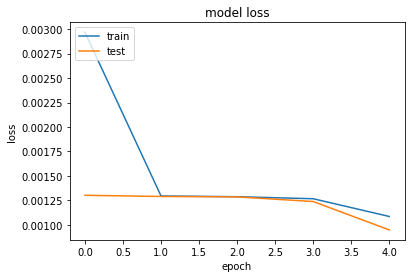

In [323]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
### Example checks

In [25]:
emb1 = model_s.encode("NIC+ZOE Four-Way Cardigan Blue Haze")
emb2 = model_s.encode("Jo Malone London Dark Amber & Ginger Lily Home Candle")
util.cos_sim(emb1, emb2)

tensor([[0.4579]])

In [104]:
emb1 = model_s.encode("NIC+ZOE Four-Way Cardigan Blue Haze")
emb2 = model_s.encode("NIC+ZOE Calm Waters Open Cardigan BLUE HAZE LARGE")
util.cos_sim(emb1, emb2)

tensor([[0.7694]])

In [331]:
encoded_1 = encoder.predict(emb1[None])[0]
reco_1 = decoder.predict(encoded_1[None])[0]

In [332]:
encoded_2 = encoder.predict(emb2[None])[0]
reco_2 = decoder.predict(encoded_2[None])[0]

In [333]:
print(emb1.shape, encoded_1.shape)

(768,) (500,)


In [334]:
util.cos_sim(encoded_1, encoded_2)

tensor([[0.9888]])

In [335]:
util.cos_sim(reco_1, reco_2)

tensor([[0.9318]])

### new try - Architecture 1

In [66]:
emb_dim = 768
hidden_layer_1_size = 600
hidden_layer_2_size = 500

In [78]:
input_emb = Input(shape=(emb_dim,))
hidden_1 = Dense(hidden_layer_1_size, activation='relu')(input_emb)
latent = Dense(hidden_layer_2_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_layer_1_size, activation='relu')(latent)
output_emb = Dense(emb_dim, activation='sigmoid')(hidden_2)

autoencoder = Model(input_emb, output_emb)
autoencoder.compile(optimizer='adamax', loss='binary_crossentropy')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [79]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 768)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 600)               461400    
_________________________________________________________________
dense_10 (Dense)             (None, 500)               300500    
_________________________________________________________________
dense_11 (Dense)             (None, 600)               300600    
_________________________________________________________________
dense_12 (Dense)             (None, 768)               461568    
Total params: 1,524,068
Trainable params: 1,524,068
Non-trainable params: 0
_________________________________________________________________


In [80]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=5, validation_data=[X_test, X_test])

Train on 44899 samples, validate on 4989 samples
Epoch 1/5
44899/44899 [==============================] - 40s 902us/step - loss: -36816158.6603 - val_loss: -193889060.6727
Epoch 2/5
44899/44899 [==============================] - 40s 883us/step - loss: -1271813019.9012 - val_loss: -3344602076.2349
Epoch 3/5
44899/44899 [==============================] - 41s 909us/step - loss: -8801266476.9920 - val_loss: -17006297471.4099
Epoch 4/5
44899/44899 [==============================] - 40s 895us/step - loss: -32965200905.2823 - val_loss: -54307581134.2778
Epoch 5/5
44899/44899 [==============================] - 40s 889us/step - loss: -89088522443.0256 - val_loss: -132817257709.0656


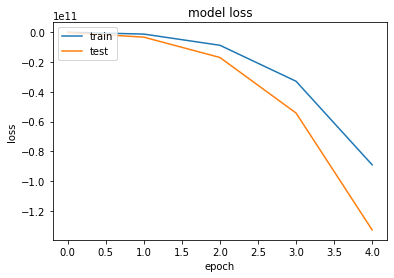

In [81]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [426]:
encoder = Sequential()
encoder.add(InputLayer((emb_dim, )))
encoder.add(Dense(hidden_layer_1_size, activation='relu'))
encoder.add(Dense(hidden_layer_2_size, activation='linear'))

decoder = Sequential()
decoder.add(InputLayer((hidden_layer_2_size, )))
decoder.add(Dense(hidden_layer_1_size, activation='relu'))
decoder.add(Dense(emb_dim, activation='linear')) 

In [427]:
inp = Input((emb_dim, ))
code = encoder(inp)
reconstruction = decoder(code)

autoencoder_1 = Model(inp, reconstruction)
autoencoder_1.compile(optimizer='adam', loss='cosine_similarity')

autoencoder_1.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        (None, 768)               0         
_________________________________________________________________
sequential_27 (Sequential)   (None, 500)               761900    
_________________________________________________________________
sequential_28 (Sequential)   (None, 768)               762168    
Total params: 1,524,068
Trainable params: 1,524,068
Non-trainable params: 0
_________________________________________________________________


In [428]:
history = autoencoder_1.fit(x=X_train, y=X_train, epochs=10, validation_data=[X_test, X_test])

Train on 44899 samples, validate on 4989 samples
Epoch 1/10
44899/44899 [==============================] - 32s 721us/step - loss: -0.9198 - val_loss: -0.9618
Epoch 2/10
44899/44899 [==============================] - 31s 681us/step - loss: -0.9755 - val_loss: -0.9762
Epoch 3/10
44899/44899 [==============================] - 30s 677us/step - loss: -0.9815 - val_loss: -0.9791
Epoch 4/10
44899/44899 [==============================] - 32s 716us/step - loss: -0.9843 - val_loss: -0.9820
Epoch 5/10
44899/44899 [==============================] - 32s 707us/step - loss: -0.9859 - val_loss: -0.9812
Epoch 6/10
44899/44899 [==============================] - 34s 763us/step - loss: -0.9870 - val_loss: -0.9844
Epoch 7/10
44899/44899 [==============================] - 36s 797us/step - loss: -0.9879 - val_loss: -0.9848
Epoch 8/10
44899/44899 [==============================] - 38s 856us/step - loss: -0.9886 - val_loss: -0.9863
Epoch 9/10
44899/44899 [==============================] - 38s 854us/step - loss

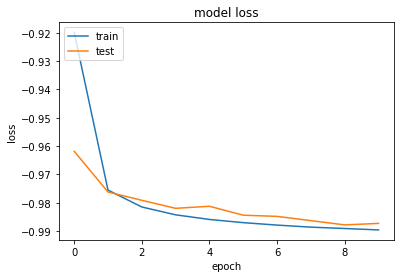

In [429]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [444]:
emb1 = model_s.encode("Nike running shoes compact and smooth 5 X size")
emb2 = model_s.encode("Nike running shoes compact and smooth 7 X size")
util.cos_sim(emb1, emb2)

tensor([[0.9257]])

In [437]:
emb1 = model_s.encode("NIC+ZOE Four-Way Cardigan Blue Haze")
emb2 = model_s.encode("Jo Malone London Dark Amber & Ginger Lily Home Candle")
util.cos_sim(emb1, emb2)

tensor([[0.4579]])

In [430]:
emb1 = model_s.encode("NIC+ZOE Four-Way Cardigan Blue Haze")
emb2 = model_s.encode("NIC+ZOE Calm Waters Open Cardigan BLUE HAZE LARGE")
util.cos_sim(emb1, emb2)

tensor([[0.7694]])

In [445]:
test_t = np.vstack((emb1, emb2))
test_t.shape

(2, 768)

In [446]:
code_1 = encoder.predict(emb1[None])[0]
reco_1 = decoder.predict(code_1[None])[0]
print(code_1.shape, reco_1.shape)

(500,) (768,)


In [447]:
code_2 = encoder.predict(emb2[None])[0]
reco_2 = decoder.predict(code_2[None])[0]
print(code_2.shape, reco_2.shape)

(500,) (768,)


In [448]:
print(util.cos_sim(reco_1, emb1))
print(util.cos_sim(reco_2, emb2))

tensor([[0.9811]])
tensor([[0.9808]])


In [449]:
util.cos_sim(reco_1, reco_2)

tensor([[0.9278]])

In [450]:
util.cos_sim(code_1, code_2)

tensor([[0.9206]])

In [326]:
res = autoencoder_1.predict(test_t)
util.cos_sim(res[0], res[1])

tensor([[0.6439]])

In [357]:
autoencoder_1.save('models/autoencoder_best')
encoder.save('models/encoder_best')
decoder.save('models/decoder_best')

In [ ]:
encoder = keras.models.load_model('models/encoder_best')
decoder = keras.models.load_model('models/decoder_best')
autoencoder_1 = keras.models.load_model('models/autoencoder_best')

### Architecture - 2

In [497]:
emb_dim = 768
hidden_layer_1_size = 700
hidden_layer_2_size = 600

In [498]:
encoder = Sequential()
encoder.add(InputLayer((emb_dim, )))
encoder.add(Dense(hidden_layer_1_size, activation='relu'))
encoder.add(Dense(hidden_layer_2_size, activation='linear'))

decoder = Sequential()
decoder.add(InputLayer((hidden_layer_2_size, )))
decoder.add(Dense(hidden_layer_1_size, activation='relu'))
decoder.add(Dense(emb_dim, activation='linear')) 

In [499]:
inp = Input((emb_dim, ))
code = encoder(inp)
reconstruction = decoder(code)

autoencoder_1 = Model(inp, reconstruction)
autoencoder_1.compile(optimizer='adam', loss='cosine_similarity')

autoencoder_1.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        (None, 768)               0         
_________________________________________________________________
sequential_33 (Sequential)   (None, 600)               958900    
_________________________________________________________________
sequential_34 (Sequential)   (None, 768)               959068    
Total params: 1,917,968
Trainable params: 1,917,968
Non-trainable params: 0
_________________________________________________________________


In [500]:
history = autoencoder_1.fit(x=X_train, y=X_train, epochs=10, validation_data=[X_test, X_test])

Train on 44899 samples, validate on 4989 samples
Epoch 1/10
44899/44899 [==============================] - 56s 1ms/step - loss: -0.9033 - val_loss: -0.9537
Epoch 2/10
44899/44899 [==============================] - 54s 1ms/step - loss: -0.9664 - val_loss: -0.9657
Epoch 3/10
44899/44899 [==============================] - 54s 1ms/step - loss: -0.9743 - val_loss: -0.9739
Epoch 4/10
44899/44899 [==============================] - 55s 1ms/step - loss: -0.9779 - val_loss: -0.9728
Epoch 5/10
44899/44899 [==============================] - 55s 1ms/step - loss: -0.9801 - val_loss: -0.9786
Epoch 6/10
44899/44899 [==============================] - 54s 1ms/step - loss: -0.9817 - val_loss: -0.9769
Epoch 7/10
44899/44899 [==============================] - 54s 1ms/step - loss: -0.9827 - val_loss: -0.9782
Epoch 8/10
44899/44899 [==============================] - 54s 1ms/step - loss: -0.9835 - val_loss: -0.9800
Epoch 9/10
44899/44899 [==============================] - 55s 1ms/step - loss: -0.9842 - val_lo

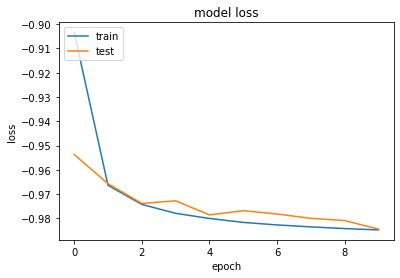

In [501]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [502]:
emb1 = model_s.encode("Nike running shoes compact and smooth 5 X size")
emb2 = model_s.encode("Nike running shoes compact and smooth 7 X size")
util.cos_sim(emb1, emb2)

tensor([[0.9257]])

In [508]:
emb1 = model_s.encode("NIC+ZOE Four-Way Cardigan Blue Haze")
emb2 = model_s.encode("Jo Malone London Dark Amber & Ginger Lily Home Candle")
util.cos_sim(emb1, emb2)

tensor([[0.4579]])

In [514]:
emb1 = model_s.encode("NIC+ZOE Four-Way Cardigan Blue Haze")
emb2 = model_s.encode("NIC+ZOE Calm Waters Open Cardigan BLUE HAZE LARGE")
util.cos_sim(emb1, emb2)

tensor([[0.7694]])

In [515]:
test_t = np.vstack((emb1, emb2))
test_t.shape

(2, 768)

In [516]:
code_1 = encoder.predict(emb1[None])[0]
reco_1 = decoder.predict(code_1[None])[0]
print(code_1.shape, reco_1.shape) 

code_2 = encoder.predict(emb2[None])[0]
reco_2 = decoder.predict(code_2[None])[0]
print(code_2.shape, reco_2.shape)

(600,) (768,)
(600,) (768,)


In [517]:
print(util.cos_sim(reco_1, emb1))
print(util.cos_sim(reco_2, emb2))

tensor([[0.9829]])
tensor([[0.9863]])


In [518]:
util.cos_sim(reco_1, reco_2)

tensor([[0.7878]])

In [519]:
util.cos_sim(code_1, code_2)

tensor([[0.9467]])